In [1]:
import numpy as np
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import matplotlib
import cv2
import rasterio
from pyproj import Proj, transform
from osgeo import gdal, gdal_array

In [2]:
#read in file
f = h5py.File('VNP09GA.A2023100.h08v05.002.2023105183328.h5','r')

In [3]:
#add contents of file to list
allList=[]
f.visit(allList.append)
allList

['HDFEOS',
 'HDFEOS/ADDITIONAL',
 'HDFEOS/ADDITIONAL/FILE_ATTRIBUTES',
 'HDFEOS/GRIDS',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/Projection',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorAzimuth_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorZenith_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarAzimuth_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarZenith_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M10_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M11_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M1_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M2_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M7_1',
 'HDFEOS/G

In [4]:
#get the gridtypes - one should be ~463m and the other ~926m
gridTypes=list(f['HDFEOS/GRIDS'].keys())

#make dictionary for separate gridtypes
allH5Datasets={}
for g in gridTypes:
    allH5Datasets[g]=[]

#put all h5 datasets within each gridtype in respective dictionary entry
for item in allList:
    gridCheck=[g in item for g in gridTypes]
    if True in gridCheck and type(f[item]) is h5py.Dataset:
        matchingGrid=[g for g, boolCheck in zip(gridTypes,gridCheck) if boolCheck][0] #need 0 here because output is list
        allH5Datasets[matchingGrid].append(item)

allH5Datasets

{'VIIRS_Grid_1km_2D': ['HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/Projection',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorAzimuth_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorZenith_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarAzimuth_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarZenith_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M10_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M11_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M1_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M2_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M7_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M8_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_QF1_1',
  'HDFEOS/GRIDS

In [5]:
possible_M_bands=['_M'+str(i)+'_' for i in range(1,12)]
possible_I_bands=['_I'+str(i)+'_' for i in range(1,4)]

print(possible_M_bands,possible_I_bands)

['_M1_', '_M2_', '_M3_', '_M4_', '_M5_', '_M6_', '_M7_', '_M8_', '_M9_', '_M10_', '_M11_'] ['_I1_', '_I2_', '_I3_']


In [6]:
#group the M & I bands into lists - M band is 926m while I band is 463m
M_bands=[]
for M in possible_M_bands: #nested for loop - not great but fine here
    for H5Dataset in allH5Datasets['VIIRS_Grid_1km_2D']:
        if M in H5Dataset:
            M_bands.append(H5Dataset)
            continue

I_bands=[]
for I in possible_I_bands:
    for H5Dataset in allH5Datasets['VIIRS_Grid_500m_2D']:
        if I in H5Dataset:
            I_bands.append(H5Dataset)
            continue


M_bands,I_bands

(['HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M1_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M2_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M7_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M8_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M10_1',
  'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M11_1'],
 ['HDFEOS/GRIDS/VIIRS_Grid_500m_2D/Data Fields/SurfReflect_I1_1',
  'HDFEOS/GRIDS/VIIRS_Grid_500m_2D/Data Fields/SurfReflect_I2_1',
  'HDFEOS/GRIDS/VIIRS_Grid_500m_2D/Data Fields/SurfReflect_I3_1'])

In [7]:
j=gdal.Open('VNP09GA.A2023100.h08v05.002.2023105183328.h5')

/Users/bwal/anaconda3/envs/analysis/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [8]:
mbandSubsets=[i[0] for i in j.GetSubDatasets() for mb in M_bands if mb.replace(' ','_') in i[0]]
mbandSubsets.sort()

ibandSubsets=[i[0] for i in j.GetSubDatasets() for ib in I_bands if ib.replace(' ','_') in i[0]]
ibandSubsets.sort()

mbandSubsets,ibandSubsets

(['HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M10_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M11_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M1_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M2_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M3_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M4_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M5_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.2023105183328.h5"://HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data_Fields/SurfReflect_M7_1',
  'HDF5:"VNP09GA.A2023100.h08v05.002.202310518

In [9]:
gdal.Open(mbandSubsets[0]).GetProjection()

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [10]:
band=gdal.Open(mbandSubsets[-3])
band_np=band.ReadAsArray()

In [11]:
bandInfo=band.GetGeoTransform()

ulx=bandInfo[0]
uly=bandInfo[3]

xSize=bandInfo[1]
ySize=bandInfo[5]

numX=band.RasterXSize
numY=band.RasterYSize

In [12]:
xVals=np.arange(ulx,ulx+(numX)*xSize,xSize)
yVals=np.arange(uly,uly+(numY)*ySize,ySize)

xx,yy=np.meshgrid(xVals,yVals)

In [13]:
coords={'x':xx[0,:],
        'y':yy[:,0],
       }

dims=('y','x')

In [14]:
bandXr=xr.DataArray(band_np,dims=dims,coords=coords)*1e-4

In [15]:
projection_info = (
    '+proj=sinu '  # Projection type (Sinusoidal)
    '+a=6371007.181 '  # Semi-major axis of the custom spheroid
    '+units=m '  # Units (Meters)
    '+lon_0=0 '  # Longitude of center
    '+x_0=0 '  # False easting
    '+y_0=0'  # False northing
)

custom_spheroid_proj = Proj(projection_info)
ca_albers=Proj('epsg:3310')

In [16]:
transXX,transYY=transform(custom_spheroid_proj,ca_albers,xx,yy)

/var/folders/s7/_qgrlcvx3nnb91r45lq895z40000gn/T/ipykernel_64965/744536621.py:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  transXX,transYY=transform(custom_spheroid_proj,ca_albers,xx,yy)


In [17]:
newX=np.arange(transXX.min(),transXX.max(),xSize)
newY=np.arange(transYY.max(),transYY.min(),ySize)

newXgrid,newYgrid=np.meshgrid(newX,newY)

In [30]:
transXX

array([[-897835.82098927, -896913.0386706 , -895990.24454369, ...,
         211713.02978098,  212641.21961803,  213569.40665556],
       [-896587.2347787 , -895664.44221946, -894741.63787129, ...,
         212960.87788108,  213889.05694026,  214817.2331842 ],
       [-895338.8786986 , -894416.07591045, -893493.26135267, ...,
         214208.4904883 ,  215136.65877196,  216064.82422465],
       ...,
       [ 436516.48344587,  437449.25926091,  438382.03056751, ...,
        1547086.87175633, 1548007.3913368 , 1548927.89496313],
       [ 437500.83844035,  438433.62444518,  439366.40593216, ...,
        1548077.14329378, 1548997.66293344, 1549918.16661144],
       [ 438484.98103484,  439417.77723707,  440350.56891207, ...,
        1549067.21503352, 1549987.7347456 , 1550908.23848849]])

In [29]:
xx

array([[-11119505.196667  , -11118578.57123394, -11117651.94580089, ...,
        -10010334.55329935, -10009407.92786629, -10008481.30243324],
       [-11119505.196667  , -11118578.57123394, -11117651.94580089, ...,
        -10010334.55329935, -10009407.92786629, -10008481.30243324],
       [-11119505.196667  , -11118578.57123394, -11117651.94580089, ...,
        -10010334.55329935, -10009407.92786629, -10008481.30243324],
       ...,
       [-11119505.196667  , -11118578.57123394, -11117651.94580089, ...,
        -10010334.55329935, -10009407.92786629, -10008481.30243324],
       [-11119505.196667  , -11118578.57123394, -11117651.94580089, ...,
        -10010334.55329935, -10009407.92786629, -10008481.30243324],
       [-11119505.196667  , -11118578.57123394, -11117651.94580089, ...,
        -10010334.55329935, -10009407.92786629, -10008481.30243324]])

In [28]:
yy

array([[4447802.078667  , 4447802.078667  , 4447802.078667  , ...,
        4447802.078667  , 4447802.078667  , 4447802.078667  ],
       [4446875.45323394, 4446875.45323394, 4446875.45323394, ...,
        4446875.45323394, 4446875.45323394, 4446875.45323394],
       [4445948.82780089, 4445948.82780089, 4445948.82780089, ...,
        4445948.82780089, 4445948.82780089, 4445948.82780089],
       ...,
       [3338631.43529935, 3338631.43529935, 3338631.43529935, ...,
        3338631.43529935, 3338631.43529935, 3338631.43529935],
       [3337704.80986629, 3337704.80986629, 3337704.80986629, ...,
        3337704.80986629, 3337704.80986629, 3337704.80986629],
       [3336778.18443323, 3336778.18443323, 3336778.18443323, ...,
        3336778.18443323, 3336778.18443323, 3336778.18443323]])

In [22]:
newX

array([-897835.82098927, -896909.19555621, -895982.57012316, ...,
       1548455.32227804, 1549381.9477111 , 1550308.57314416])

In [18]:
newY

array([ 270420.26584534,  269493.64041228,  268567.01497923, ...,
       -874888.7694117 , -875815.39484476, -876742.02027781])

In [19]:
projX,projY=transform(ca_albers,custom_spheroid_proj,newXgrid,newYgrid)

projX = xr.DataArray(projX,coords={'y':range(newXgrid.shape[0]),'x':range(newXgrid.shape[1])},dims=('y','x'))
projY = xr.DataArray(projY,coords={'y':range(newXgrid.shape[0]),'x':range(newXgrid.shape[1])},dims=('y','x'))

/var/folders/s7/_qgrlcvx3nnb91r45lq895z40000gn/T/ipykernel_64965/3870301730.py:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projX,projY=transform(ca_albers,custom_spheroid_proj,newXgrid,newYgrid)


In [20]:
bandInterp = bandXr.interp(y=projY,x=projX,method='nearest')

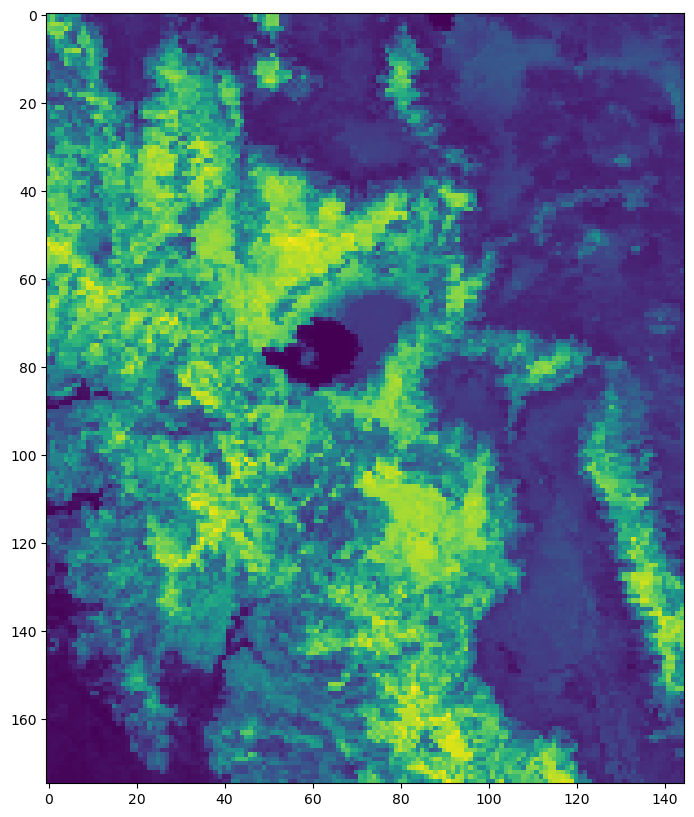

In [21]:
fig,axs=plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

ax=axs
ax.imshow(bandInterp[215:390,1000:1145])#[215:390,1000:1145])
#ax.imshow(pan[430:780,2000:2290])

#ax.imshow(np.where(r<0,np.nan,r)[430:780,2000:2290])
#ax.imshow(pan[430:780,2000:2290])

#ax.imshow(np.where(r<0,np.nan,r)[:5,:5])
#ax.imshow(np.where(r<0,np.nan,r)[:10,:10])
#ax.imshow(pan[:10,:10])

#ax.imshow(np.where(r<0,np.nan,r)[:50,:50])
#ax.imshow(pan[:100,:100])

#ax.imshow(rgb[180:300,750:900])
#ax.imshow(cv2.resize(rgb,dsize=None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)[430:780,2000:2290])

plt.show()
plt.close()